# 1) Importing Libraries

In [ ]:
# Default libraries, packages for data management, visualization and Computer vision libraries
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Sklearn package -> function
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Tensorflow packages
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Conv2D, MaxPool2D,
                                     BatchNormalization, Flatten, GlobalAveragePooling2D, Input)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.applications import EfficientNetB7, MobileNetV2, VGG19, DenseNet121

# 2) Helper Functions & Hyperparameters

In [ ]:
def directory_to_df(path : str):
    """
    This function to retrieve all images from targeted folder in a file, the
    folder must be divided hirarchally in which each class contains its images individually.
    ________________________________________________________________________________________________
    Arguments-

    path: String -> the main folder directory that contains train/test folders

    ________________________________________________________________________________________________
    Return-

    DataFrame: contains the images path and label corresponding to every image
    """
    df = []
    chars = 'abcdefghijklmnopqrstuvwxyz'    # to include lowercase letters only
    for cls in os.listdir(path):
        cls_path = os.path.join(path,cls)
        cls_name = cls.split('_')[0]
        if not cls_name in chars:
            continue
        for img_path in os.listdir(cls_path):
            direct = os.path.join(cls_path,img_path)
            df.append([direct,cls_name])

    df = pd.DataFrame(df, columns=['image','label'])
    print("The number of samples found:",len(df))
    return df.copy()

def read_image(path):
    """
    Read an image from specified directory
    _____________________________________________________________
    Arguments:

    path: String -> a directory of the image
    _____________________________________________________________
    Return:

    image: numpy.array of the image
    """
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def show_image(img, label=None) -> None:
    """
    This function to display any image
    _________________________________________________________
    Arguements:

    img: numpy.array of N-D

    label: String -> the title/label added with the image, Default= None
    _________________________________________________________
    Return:

    plt.imshow()
    """
    plt.imshow(img, cmap='gray')
    plt.axis(False)
    plt.title(label)
    plt.show()

def clbck(model_name):
    # The function is defined to make the callbacks for training the models
    ERLY = EarlyStopping(patience=10, min_delta=0.01, start_from_epoch=10, verbose=1)
    RD = ReduceLROnPlateau(patience=5, min_delta=0.01, factor=0.5)
    CHK = ModelCheckpoint(f'{model_name}_model.h5',verbose=1, save_best_only=True)
    return [ERLY,RD,CHK]

In [ ]:
# Pre-defined hyperparameters
IMG_SHAPE = (32,32)
IMG_SIZE = (32,32,3)
BATCH_SIZE = 32
opt = Adam(learning_rate=0.00001, epsilon=1e-6)
loss = 'categorical_crossentropy'
EPOCHS = 10

# 3) Reading & preparing the dataset

In [ ]:
# Reading the dataset in dataframe
main_path = '/kaggle/input/ocr-dataset/dataset'
df = directory_to_df(main_path)                   # convert the dataset into df of two columns
df.head()

The number of samples found: 85199


,image,label
0,/kaggle/input/ocr-dataset/dataset/c_L/C_L_1241...,c
1,/kaggle/input/ocr-dataset/dataset/c_L/C_L_3096...,c
2,/kaggle/input/ocr-dataset/dataset/c_L/C_L_3184...,c
3,/kaggle/input/ocr-dataset/dataset/c_L/C_L_2981...,c
4,/kaggle/input/ocr-dataset/dataset/c_L/C_L_1635...,c


In [ ]:
df['label'].value_counts()

label
r    3284
e    3284
n    3281
a    3281
m    3281
q    3279
u    3278
i    3277
d    3277
y    3276
x    3276
s    3276
l    3276
k    3276
t    3276
g    3275
w    3275
h    3275
z    3275
f    3275
p    3275
o    3275
b    3274
c    3274
j    3274
v    3274
Name: count, dtype: int64

## 3.1) Splitting the dataframe
- The dataframe is splitted to get 70% of the dataset for `training` , and 30% for `testing`
- The training set is splitted into `training` and `validation` to enhance the model training

In [ ]:
# Splitting for training & testing (70,30 respectively)
X, y = df['image'], df['label']
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.30, random_state=41)
training_df = pd.concat((X_train,y_train), axis=1)
testing_df = pd.concat((X_test,y_test), axis=1)

In [ ]:
# Splitting for training & validation (75,25 respectively) -> the training set size = 52.5%
X, y = training_df['image'], training_df['label']
X_train, X_valid, y_train, y_valid = train_test_split(X,y , test_size=0.25, random_state=41)
training_df = pd.concat((X_train,y_train), axis=1)
validation_df = pd.concat((X_valid,y_valid), axis=1)

## 3.2) Creating generators
- The `ImageDataGenerators` is used for data augmentation, the augmentation is required since the `OCR` can work with different brightness which is not included in the dataset.
- Also, it enhance the RAM usage.

In [ ]:
# Creating generators
gen = ImageDataGenerator(dtype=np.int32, brightness_range=[0.0,1.0], fill_mode='nearest')
gen2 = ImageDataGenerator(dtype=np.int32, fill_mode='nearest')
train_gen = gen.flow_from_dataframe(training_df, x_col='image',y_col='label', batch_size=BATCH_SIZE,
                                   target_size=IMG_SHAPE)
valid_gen = gen2.flow_from_dataframe(validation_df, x_col='image', y_col='label', batch_size=BATCH_SIZE,
                                        target_size=IMG_SHAPE, shuffle=False)
test_gen = gen2.flow_from_dataframe(testing_df, x_col='image', y_col='label', batch_size=BATCH_SIZE,
                                       target_size=IMG_SHAPE, shuffle=False)

Found 44729 validated image filenames belonging to 26 classes.
Found 14910 validated image filenames belonging to 26 classes.
Found 25560 validated image filenames belonging to 26 classes.


In [ ]:
# Making a mapping of the classes and the inverse for later processings
mapping = train_gen.class_indices
mapping_inverse = dict(map(lambda x: tuple(reversed(x)), mapping.items()))

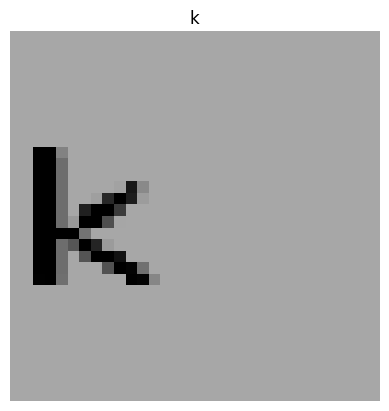

The shape of the image: (32, 32, 3)


In [ ]:
# Reading a sample from the dataset
BATCH_NUM = 10
IMG_NUM = 2      # from 0 to 31
show_image(train_gen[BATCH_NUM][0][IMG_NUM],mapping_inverse[train_gen[BATCH_NUM][1][IMG_NUM].argmax()])
print('The shape of the image:',train_gen[BATCH_NUM][0][IMG_NUM].shape)

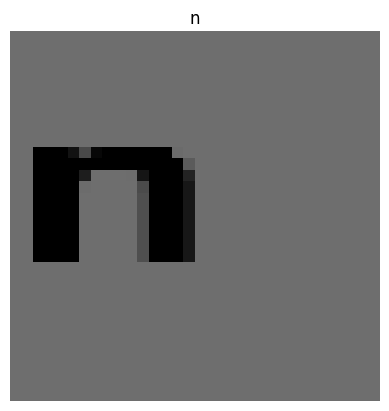

The shape of the image: (32, 32, 3)


In [ ]:
# Reading another sample from the dataset
BATCH_NUM = 65
IMG_NUM = 30      # from 0 to 31
show_image(train_gen[BATCH_NUM][0][IMG_NUM],mapping_inverse[train_gen[BATCH_NUM][1][IMG_NUM].argmax()])
print('The shape of the image:',train_gen[BATCH_NUM][0][IMG_NUM].shape)

# 4) Modeling
*Our target is to build a **`custom CNN model`** to train on our targeted images for the `OCR` application. in advance, we also will use 4 Pre-trained models as part of `Transfer Learning` and to enhance the performance of the application.*

***Our targeted pretrained models are the following:***

*- EfficientNetB7*

*- MobileNetV2*

*- VGG19*

*- DenseNet121*

***The fine-tuning strategy:*** *using a small value of `LR` of the optimizer `Adam` will make an efficient use of the pre-trained models on our dataset without **FREEZING** the input layers in which better performance is required in our case*

## 4.1) Custom CNN

In [ ]:
# Custom CNN
CNN_model = Sequential()
CNN_model.add(Input(shape=IMG_SIZE, batch_size=BATCH_SIZE, name='Input'))
CNN_model.add(Conv2D(3, (3,3), strides=1, activation='relu', padding='same'))
CNN_model.add(Conv2D(128, (3,3), activation='relu'))
CNN_model.add(MaxPool2D((3,3)))
CNN_model.add(Conv2D(256, (3,3), activation='relu'))
CNN_model.add(Dropout(0.2))
CNN_model.add(Conv2D(256, (3,3), strides=2, activation='relu', padding='same'))
CNN_model.add(MaxPool2D((2,2)))
CNN_model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
CNN_model.add(Dropout(0.2))
CNN_model.add(Conv2D(1024, (2,2), activation='relu', padding='same'))
CNN_model.add(MaxPool2D(2,2))
CNN_model.add(Flatten())
CNN_model.add(Dense(1024, activation='selu'))
CNN_model.add(Dense(len(mapping), activation='softmax'))

In [ ]:
CNN_model = Sequential()
CNN_model.add(Input(shape=(32, 32, 3), name='Input'))
CNN_model.add(Conv2D(3, (3,3), strides=1, activation='relu', padding='same'))
CNN_model.add(Conv2D(128, (3,3), activation='relu'))
CNN_model.add(MaxPool2D((3,3)))
CNN_model.add(Conv2D(256, (3,3), activation='relu'))
CNN_model.add(Dropout(0.2))
CNN_model.add(Conv2D(256, (3,3), strides=2, activation='relu', padding='same'))
CNN_model.add(MaxPool2D((2,2)))
CNN_model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
CNN_model.add(Dropout(0.2))
CNN_model.add(Conv2D(1024, (2,2), activation='relu', padding='same'))
CNN_model.add(MaxPool2D((2,2)))
CNN_model.add(Flatten())
CNN_model.add(Dense(1024, activation='selu'))
CNN_model.add(Dense(len(mapping), activation='softmax'))


In [ ]:
CNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 3)         84        
                                                                 
 conv2d_7 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 10, 10, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 256)         295168    
                                                                 
 dropout_2 (Dropout)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 4, 4, 256)         590080    
                                                      

In [ ]:
# Default parameters of adam will be used for the custom CNN
CNN_model.compile(optimizer=Adam(), loss=loss, metrics=['accuracy'])

In [ ]:
print(CNN_model.input_shape)
print(train_gen.image_shape)  # If using ImageDataGenerator


(None, 32, 32, 3)
(32, 32, 3)


In [ ]:
print(train_gen[0][0].shape)  # First batch of images


(32, 32, 32, 3)


In [ ]:
# different num. of epochs will be given for better convergence for the Custom CNN
history = CNN_model.fit(train_gen, epochs=20, validation_data=valid_gen, callbacks=clbck("CustomCnn"))

Epoch 1/20


2025-03-28 21:52:08.960126: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1398/1398 [==============================] - ETA: 0s - loss: 1.0003 - accuracy: 0.7216
Epoch 1: val_loss improved from inf to 0.48636, saving model to CustomCnn_model.h5
1398/1398 [==============================] - 275s 195ms/step - loss: 1.0003 - accuracy: 0.7216 - val_loss: 0.4864 - val_accuracy: 0.8789 - lr: 0.0010
Epoch 2/20


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1398/1398 [==============================] - ETA: 0s - loss: 0.4567 - accuracy: 0.8761
Epoch 2: val_loss did not improve from 0.48636
1398/1398 [==============================] - 57s 41ms/step - loss: 0.4567 - accuracy: 0.8761 - val_loss: 0.6091 - val_accuracy: 0.8625 - lr: 0.0010
Epoch 3/20
1397/1398 [============================>.] - ETA: 0s - loss: 0.3816 - accuracy: 0.8999
Epoch 3: val_loss improved from 0.48636 to 0.37401, saving model to CustomCnn_model.h5
1398/1398 [==============================] - 57s 41ms/step - loss: 0.3827 - accuracy: 0.8998 - val_loss: 0.3740 - val_accuracy: 0.9089 - lr: 0.0010
Epoch 4/20
1398/1398 [==============================] - ETA: 0s - loss: 0.3554 - accuracy: 0.9057
Epoch 4: val_loss improved from 0.37401 to 0.32241, saving model to CustomCnn_model.h5
1398/1398 [==============================] - 63s 45ms/step - loss: 0.3554 - accuracy: 0.9057 - val_loss: 0.3224 - val_accuracy: 0.9239 - lr: 0.0010
Epoch 5/20
1398/1398 [==============================

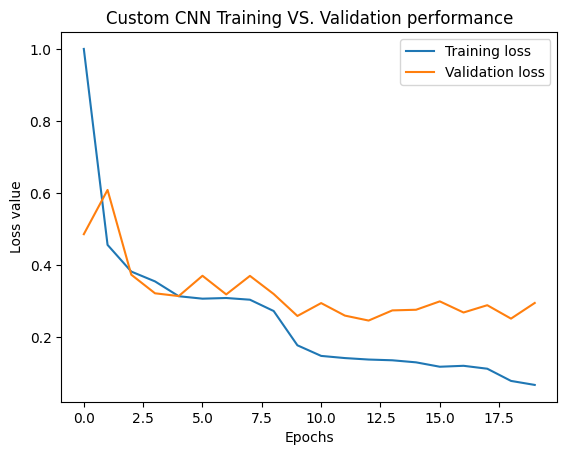

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("Custom CNN Training VS. Validation performance")
plt.show()

In [ ]:
# Making a prediction out of the Custom CNN for the testing set for the evaluation
prediction = CNN_model.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen.classes))

799/799 [==============================] - 165s 207ms/step


In [ ]:
print('\t\tThe Custom CNN Evaluation Performance')
print(classification_report(y_test, pred))

		The Custom CNN Evaluation Performance
              precision    recall  f1-score   support

           a       0.95      0.94      0.94       992
           b       0.96      0.96      0.96       929
           c       0.94      0.97      0.95      1008
           d       0.98      0.97      0.97       999
           e       0.93      0.94      0.93       973
           f       0.95      0.97      0.96      1000
           g       0.95      0.95      0.95       957
           h       0.97      0.94      0.96       973
           i       0.96      0.94      0.95       969
           j       0.97      0.97      0.97       931
           k       0.94      0.98      0.96      1000
           l       0.93      0.95      0.94       974
           m       0.95      0.98      0.96      1005
           n       0.93      0.94      0.93       951
           o       0.95      0.95      0.95       951
           p       0.97      0.97      0.97       982
           q       0.98      0.96      0.

# 5) Post-Processing
#### **THIS SECTION IS ABOUT `Computer Vision` TECHNIQUES**

*the image will be taken from the user/externally to be processed and input into our model. some **LOW LEVEL COMPUTER VISION TECHNIQUES** are used in order to enhance the input image, wheter it is text or handwritten, these techniques are the following:*

- **Binarization:** The binarization function applies Otsu's binarization to the grayscale image, producing a binary image.

- **Dilate:** The dilate function performs morphological dilation on the binary image. The degree of dilation is adjusted based on whether processing `words` or `characters`.

- **Find Rectangles:** The find_rect function identifies bounding rectangles in the binary image, sorting them based on their **x-coordinate (From Left-to-Right)**.

- **Extract Characters:** The extract function uses the aforementioned techniques to extract characters from the image. It identifies words **FIRST**, then extracts characters from each word, and with the use of the pre-trained deep learning model to recognize each character.

# Working

In [ ]:
# Computer Vision - Low level techniques
def load_model():
    model_path = '/kaggle/input/working-bettwe/tensorflow2/default/1/CustomCnn_model.h5'
    model = tf.keras.saving.load_model(model_path)
    return model

def convert_2_gray(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return gray_image

def binarization(image):
    img, thresh = cv2.threshold(image, 0,255, cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)
    return img, thresh

def dilate(image, words= False):
    img = image.copy()
    m = 3
    n = m - 2                   # n less than m for Vertical structuring element to dilate chars
    itrs = 4
    if words:
        m = 6
        n = m
        itrs = 3
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (n, m))
    dilation = cv2.dilate(img, rect_kernel, iterations = itrs)
    return dilation

def find_rect(image):
    contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    rects = []

    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)  # Extract the bounding rectangle coordinates of each countour
        rects.append([x,y,w,h])

    sorted_rects = list(sorted(rects, key=lambda x: x[0])) # Sorting the rects from Left-to-Right
    return sorted_rects

def extract(image):
    model = load_model()
    chars = []              # a list to store recognized characters

    image_cpy = image.copy()
    _, bin_img = binarization(convert_2_gray(image_cpy))
    full_dil_img = dilate(bin_img,words=True)
    words = find_rect(full_dil_img)                       # Recognized words within the image
    del _, bin_img, full_dil_img                          # for better memory usage

    for word in words:
        x,y,w,h = word                                    # coordinates of the word
        img = image_cpy[y:y+h, x:x+w]

        _, bin_img = binarization(convert_2_gray(img))
        dil_img = dilate(bin_img)
        char_parts = find_rect(dil_img)                     # Recognized chars withtin the word
        cv2.rectangle(image, (x,y),(x+w,y+h), (0,255,0), 3) # draw a green rectangle around the word

        del _, bin_img, dil_img

        for char in char_parts:
            x,y,w,h = char
            ch = img[y:y+h, x:x+w]

            empty_img = np.full((32,32,1),255, dtype=np.uint8) # a white image used for resize with filling
            x,y = 3,3                                          # starting indecies
            resized = cv2.resize(ch, (16,22), interpolation=cv2.INTER_CUBIC)
            gray = convert_2_gray(resized)
            empty_img[y:y+22, x:x+16,0] = gray.copy()          # integrate the recognized char into the white image
            gray = cv2.cvtColor(empty_img, cv2.COLOR_GRAY2RGB)
            gray = gray.astype(np.int32)

            predicted = mapping_inverse[np.argmax(model.predict(np.array([gray]), verbose=-1))]
            chars.append(predicted)                            # append the character into the list

            del ch, resized, gray, empty_img
        chars.append(' ')  # at the end of each iteration (end of word) append a space

    del model
    show_image(image)
    return ''.join(chars[:-1])

## 6.1) Testing

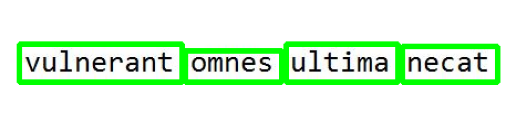

--> VULNERANT OMNES ULTIMA NECAT


In [ ]:
# Testing 1
img = read_image('/kaggle/input/testing/Capture4.JPG')
text = extract(img)
print('-->',text)

In [ ]:
pip install deep_translator

  Obtaining dependency information for deep_translator from https://files.pythonhosted.org/packages/38/3f/61a8ef73236dbea83a1a063a8af2f8e1e41a0df64f122233938391d0f175/deep_translator-1.11.4-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from deep_translator import GoogleTranslator

def translate_text(text, target_lang='en', source_lang='la'):
    return GoogleTranslator(source=source_lang, target=target_lang).translate(text)


In [ ]:
translated=translate_text(text)
print("Original text:",text)
print("Translated text:",translated)

Original text: VULNERANT OMNES ULTIMA NECAT
Translated text: Wound all the last kills
